In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time

from keras.models import Model, Sequential, load_model
import keras
from keras import optimizers
from keras.layers import Input,Bidirectional ,LSTM, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

from pathlib import Path
from datetime import timedelta
import dateutil
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [9]:
def csv2df(target):
    return pd.read_csv(target, encoding = 'utf-8').rename(columns = lambda x: x.strip())   # strip(): 인자를 전달하지 않으면 문자열에서 공백을 제거

def csvs2df(targets):
    return pd.concat([csv2df(x) for x in targets])


In [10]:
train_list = sorted([x for x in Path('C:/ProgramData/Anaconda3/data/train').glob('*.csv')])
valid_list = sorted([x for x in Path('C:/ProgramData/Anaconda3/data/validation').glob('*.csv')])
test_list  = sorted([x for x in Path('C:/ProgramData/Anaconda3/data/test').glob('*.csv')])

df_train_raw = csvs2df(train_list)

In [11]:
df_train_raw.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
count,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1004402.0,...,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06
mean,-2.068788e+00,0.0,1.224465e+01,-3.072510e-05,6.507154e+01,4.457734e-01,1.259976e+01,7.448029e+01,1.0,50.0,...,1.105578e+00,3.386906e+01,4.192900e+00,2.202201e+03,3.662623e+02,1.0,1.009977e+03,1.200010e+01,50.0,1.126177e+03
std,9.973782e-01,0.0,1.322091e-01,1.644198e-03,4.124122e+01,9.490236e-01,2.312396e-01,4.972919e+00,0.0,0.0,...,8.886521e-02,2.897106e+00,3.445795e+00,1.329775e+03,6.061224e+01,0.0,3.981555e+01,1.718555e-02,0.0,1.693609e+03
min,-4.627100e+00,0.0,1.198730e+01,-4.253000e-02,2.685500e-01,-2.146700e+00,1.203892e+01,7.000000e+01,1.0,50.0,...,5.532800e-01,2.815872e+01,0.000000e+00,1.112275e+01,2.309570e+02,1.0,8.900452e+02,1.200000e+01,50.0,-1.120000e+02
25%,-2.689100e+00,0.0,1.210938e+01,-1.090000e-03,1.500092e+01,-9.020000e-02,1.253358e+01,7.000000e+01,1.0,50.0,...,1.053010e+00,3.083306e+01,0.000000e+00,5.533513e+02,3.180339e+02,1.0,9.775195e+02,1.200000e+01,50.0,7.000000e+00
50%,-2.158600e+00,0.0,1.226196e+01,-7.000000e-05,9.403381e+01,4.304000e-01,1.266931e+01,7.000000e+01,1.0,50.0,...,1.111760e+00,3.548735e+01,5.327940e+00,3.176862e+03,3.652344e+02,1.0,1.007838e+03,1.200000e+01,50.0,1.060000e+02
75%,-1.560500e+00,0.0,1.226959e+01,1.010000e-03,1.005112e+02,8.929000e-01,1.275681e+01,8.000000e+01,1.0,50.0,...,1.165160e+00,3.602524e+01,6.862630e+00,3.184745e+03,4.146954e+02,1.0,1.030605e+03,1.200000e+01,50.0,2.376000e+03
max,8.286000e-01,0.0,1.686249e+01,4.051000e-02,1.008774e+02,3.148700e+00,1.281139e+01,8.000000e+01,1.0,50.0,...,2.088320e+00,3.805496e+01,1.000000e+01,3.190000e+03,4.997649e+02,1.0,1.121855e+03,1.714934e+01,50.0,1.299300e+04


In [12]:
valid_col_in_train = df_train_raw.columns.drop(['timestamp'])
valid_col_in_train

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [13]:
tag_min = df_train_raw[valid_col_in_train].min()
tag_max = df_train_raw[valid_col_in_train].max()

def normalize(df):
    ndf = df.copy()
    for col in df.columns:
        if tag_min[col] == tag_max[col]:
            ndf[col] = df[col] - tag_min[col]
        else:
            ndf[col] = (df[col] - tag_min[col]) / (tag_max[col] - tag_min[col])

    return ndf

def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [14]:
# REMOVE NOISE
df_train = normalize(df_train_raw[valid_col_in_train]).ewm(alpha=0.9).mean()
df_train

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,...,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,...,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,...,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,...,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,...,0.403941,0.696846,1.000000,0.996289,0.517805,0.0,0.414192,0.0,0.0,0.018717
259196,0.447224,0.0,0.056338,0.509379,0.994085,0.510481,0.640361,0.0,0.0,0.0,...,0.401381,0.695028,1.000000,0.995484,0.518674,0.0,0.414192,0.0,0.0,0.015676
259197,0.423251,0.0,0.056338,0.528358,0.994085,0.508101,0.640361,0.0,0.0,0.0,...,0.401571,0.694256,1.000000,0.995510,0.511131,0.0,0.414192,0.0,0.0,0.015440
259198,0.425407,0.0,0.056338,0.520068,0.993949,0.522157,0.640361,0.0,0.0,0.0,...,0.401590,0.693797,1.000000,0.995761,0.510014,0.0,0.414192,0.0,0.0,0.014318


In [15]:
df_train.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
count,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1004402.0,...,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06
mean,4.689247e-01,0.0,5.278706e-02,5.117928e-01,6.441084e-01,4.895708e-01,7.260389e-01,4.480288e-01,0.0,0.0,...,3.597938e-01,5.770209e-01,4.192900e-01,6.892614e-01,5.033529e-01,0.0,5.173684e-01,1.871145e-05,0.0,9.448133e-02
std,1.816325e-01,0.0,2.711736e-02,1.849803e-02,4.099142e-01,1.789313e-01,2.993505e-01,4.972917e-01,0.0,0.0,...,5.788084e-02,2.927475e-01,3.445783e-01,4.183084e-01,2.254592e-01,0.0,1.717591e-01,3.333650e-03,0.0,1.291178e-01
min,7.951789e-03,0.0,1.565067e-04,5.181067e-02,1.516766e-05,8.401645e-04,0.000000e+00,0.000000e+00,0.0,0.0,...,3.931927e-04,6.443158e-05,0.000000e+00,3.828065e-04,4.992635e-04,0.0,0.000000e+00,0.000000e+00,0.0,9.004197e-04
25%,3.573124e-01,0.0,2.504108e-02,5.000366e-01,1.464322e-01,3.895244e-01,6.403614e-01,0.000000e+00,0.0,0.0,...,3.256094e-01,2.702523e-01,0.000000e+00,1.708443e-01,3.239787e-01,0.0,3.773530e-01,0.000000e+00,0.0,9.080504e-03
50%,4.510789e-01,0.0,5.633832e-02,5.116965e-01,9.319785e-01,4.864941e-01,8.160705e-01,0.000000e+00,0.0,0.0,...,3.637849e-01,7.405417e-01,5.327940e-01,9.959473e-01,4.996203e-01,0.0,5.081413e-01,0.000000e+00,0.0,1.674958e-02
75%,5.599275e-01,0.0,5.790338e-02,5.236405e-01,9.963600e-01,5.730337e-01,9.293435e-01,1.000000e+00,0.0,0.0,...,3.986000e-01,7.949007e-01,6.862630e-01,9.983340e-01,6.835147e-01,0.0,6.063554e-01,0.000000e+00,0.0,1.900984e-01
max,9.962372e-01,0.0,9.999243e-01,9.528693e-01,9.999924e-01,9.998485e-01,1.000000e+00,1.000000e+00,0.0,0.0,...,9.997556e-01,9.999318e-01,1.000000e+00,1.000000e+00,9.993615e-01,0.0,1.000000e+00,9.951635e-01,0.0,9.042326e-01


In [16]:
WINDOW_GIVEN = 59
WINDOW_SIZE = 60

# DEFINE DATASET
def HaiDataset(timestamps, df, stride=10, attacks=None):
    ts = np.array(timestamps)
    tag_values = np.array(df, dtype=np.float32)
    valid_idxs = []

    for L in trange(len(ts) - WINDOW_SIZE + 1):
        R = L + WINDOW_SIZE - 1
        if dateutil.parser.parse(ts[R]) - dateutil.parser.parse(ts[L]) == timedelta(seconds = WINDOW_SIZE - 1):
            valid_idxs.append(L)
    
    valid_idxs = np.array(valid_idxs, dtype=np.int32)[::stride]
    n_idxs = len(valid_idxs)
    print("# of valid windows:", n_idxs)
    
    if attacks is not None:
        attacks = np.array(attacks, dtype=np.float32)
        with_attack = True
    else:
        with_attack = False
        
    timestamp, X, y, att = [], [], [], []
    
    if with_attack:
        for i in valid_idxs:
            last = i + WINDOW_SIZE - 1
            seq_time, seq_x, seq_y, seq_attack = ts[last], tag_values[i:i+WINDOW_GIVEN], tag_values[last], attacks[last]
            timestamp.append(seq_time)
            X.append(seq_x)
            y.append(seq_y)
            att.append(seq_attack)
            
        return np.array(timestamp), np.array(X), np.array(y), np.array(att)
        
    else:
        for i in valid_idxs:
            last = i + WINDOW_SIZE - 1
            seq_time, seq_x, seq_y = ts[last], tag_values[i:i+WINDOW_GIVEN], tag_values[last]
            timestamp.append(seq_time)
            X.append(seq_x)
            y.append(seq_y)

        return np.array(timestamp), np.array(X), np.array(y)

In [17]:
ts, X_train, y_train = HaiDataset(df_train_raw['timestamp'], df_train, stride=10)

  0%|          | 0/1004343 [00:00<?, ?it/s]

# of valid windows: 100405


In [18]:
df_valid_raw = csvs2df(valid_list)
df_valid = normalize(df_valid_raw[valid_col_in_train]).ewm(alpha=0.9).mean()
df_valid

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.474293,0.0,-0.040688,0.519147,0.159551,0.481116,1.119160,0.0,0.0,0.0,...,0.437871,0.339753,0.071604,0.118089,0.467573,0.0,0.624077,0.0,0.0,0.020832
1,0.451714,0.0,-0.040688,0.481925,0.156242,0.484154,1.119160,0.0,0.0,0.0,...,0.437871,0.339437,0.071604,0.125189,0.452160,0.0,0.624077,0.0,0.0,0.020416
2,0.381911,0.0,-0.042098,0.465987,0.145560,0.424951,1.119160,0.0,0.0,0.0,...,0.431603,0.338055,0.071604,0.133427,0.435862,0.0,0.624077,0.0,0.0,0.019966
3,0.393676,0.0,-0.040829,0.491074,0.143888,0.463538,1.119160,0.0,0.0,0.0,...,0.423829,0.335802,0.071604,0.142116,0.409784,0.0,0.624077,0.0,0.0,0.019852
4,0.434492,0.0,-0.042110,0.517858,0.144267,0.447745,1.119160,0.0,0.0,0.0,...,0.424389,0.335577,0.071604,0.139048,0.389922,0.0,0.624077,0.0,0.0,0.019841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.330458,0.0,0.056340,0.526499,0.151740,0.395722,0.816071,0.0,0.0,0.0,...,0.459111,0.367795,0.071604,0.372276,0.434196,0.0,0.553681,0.0,0.0,0.009081
86396,0.362960,0.0,0.056338,0.525410,0.151740,0.435508,0.816071,0.0,0.0,0.0,...,0.458786,0.367692,0.071604,0.368093,0.435414,0.0,0.553681,0.0,0.0,0.009081
86397,0.410882,0.0,0.056338,0.502541,0.151740,0.457808,0.816071,0.0,0.0,0.0,...,0.459199,0.366815,0.071604,0.360001,0.438139,0.0,0.553681,0.0,0.0,0.009081
86398,0.449047,0.0,0.056338,0.493209,0.151740,0.466378,0.816071,0.0,0.0,0.0,...,0.458795,0.365131,0.071604,0.352961,0.439501,0.0,0.553681,0.0,0.0,0.009081


In [19]:
df_valid.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
count,86400.000000,86400.0,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.0,86400.0,86400.0,...,86400.000000,86400.000000,8.640000e+04,86400.000000,86400.000000,86400.0,86400.000000,86400.000000,86400.0,86400.000000
mean,0.397315,0.0,-0.010617,0.511837,0.155582,0.437582,0.912035,0.0,0.0,0.0,...,0.365749,0.342534,7.160420e-02,0.211745,0.501816,0.0,0.493694,0.000228,0.0,0.093761
std,0.059105,0.0,0.045959,0.018408,0.100942,0.035091,0.140985,0.0,0.0,0.0,...,0.071170,0.034352,1.340047e-13,0.209803,0.219834,0.0,0.117485,0.011092,0.0,0.129266
min,0.247220,0.0,-0.045070,0.373108,0.000387,0.311288,0.816071,0.0,0.0,0.0,...,-0.141928,0.247041,7.160420e-02,0.000119,0.018319,0.0,0.279507,0.000000,0.0,0.008928
25%,0.345991,0.0,-0.040702,0.500155,0.124004,0.413280,0.816071,0.0,0.0,0.0,...,0.320935,0.322734,7.160420e-02,0.083568,0.327199,0.0,0.410605,0.000000,0.0,0.009081
50%,0.397685,0.0,-0.040688,0.511769,0.142362,0.438945,0.816071,0.0,0.0,0.0,...,0.366009,0.340920,7.160420e-02,0.155831,0.501403,0.0,0.456238,0.000000,0.0,0.015243
75%,0.450537,0.0,0.056338,0.523626,0.158474,0.466712,1.119160,0.0,0.0,0.0,...,0.410447,0.360782,7.160420e-02,0.253215,0.676365,0.0,0.553681,0.000000,0.0,0.188110
max,0.515133,0.0,0.902344,0.609929,0.625540,0.513151,1.119160,0.0,0.0,0.0,...,0.975503,0.490594,7.160420e-02,0.984262,0.986329,0.0,0.673597,0.988922,0.0,0.425755


In [20]:
boundary_check(df_valid)

(True, True, False)

In [21]:
ts, X_valid, y_valid, attack = HaiDataset(df_valid_raw['timestamp'], df_valid, attacks = df_valid_raw['attack'])

  0%|          | 0/86341 [00:00<?, ?it/s]

# of valid windows: 8635


In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(f'best_LSTM_model_{WINDOW_SIZE}seq_test.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [23]:
#################
###### LSTM MODEL
#################
n_features = df_train.shape[1]

inputs = Input(shape=(WINDOW_GIVEN, n_features))
first = Bidirectional(LSTM(100, return_sequences=True))(inputs)
second = Bidirectional(LSTM(100, return_sequences=True))(first)
third = Bidirectional(LSTM(100))(second)

lstm_out = Dense(n_features)(third)
aux_input = Input(shape = (n_features, ), name = 'aux_input')
outputs = keras.layers.add([lstm_out, aux_input])

model = Model(inputs = [inputs, aux_input], outputs = outputs)
model.compile(loss='mean_squared_error', optimizer='Adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 59, 86)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 59, 200)      149600      ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 59, 200)     240800      ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 200)         240800      ['bidirectional_1[0][0]']    

In [24]:
aux_train = []

for i in range(len(X_train)):
    aux_train.append(X_train[i][0])

aux_train = np.array(aux_train)

In [25]:
aux_valid = []

for i in range(len(X_valid)):
    aux_valid.append(X_valid[i][0])

aux_valid = np.array(aux_valid)

In [26]:
hist = model.fit([X_train, aux_train], y_train, batch_size = 1024, epochs = 50, shuffle = True,
                  callbacks = [es, mc], validation_data = ([X_valid, aux_valid], y_valid))

Epoch 1/50
99/99 [==============================] - ETA: 0s - loss: 0.0049
Epoch 1: val_loss improved from inf to 0.00554, saving model to best_LSTM_model_60seq_test.h5
99/99 [==============================] - 467s 5s/step - loss: 0.0049 - val_loss: 0.0055
Epoch 2/50
99/99 [==============================] - ETA: 0s - loss: 0.0022
Epoch 2: val_loss improved from 0.00554 to 0.00495, saving model to best_LSTM_model_60seq_test.h5
99/99 [==============================] - 564s 6s/step - loss: 0.0022 - val_loss: 0.0049
Epoch 3/50
99/99 [==============================] - ETA: 0s - loss: 0.0018
Epoch 3: val_loss improved from 0.00495 to 0.00430, saving model to best_LSTM_model_60seq_test.h5
99/99 [==============================] - 600s 6s/step - loss: 0.0018 - val_loss: 0.0043
Epoch 4/50
99/99 [==============================] - ETA: 0s - loss: 0.0015
Epoch 4: val_loss improved from 0.00430 to 0.00223, saving model to best_LSTM_model_60seq_test.h5
99/99 [==============================] - 605s 6s

In [27]:
## MODEL LOAD
model = load_model(f'best_LSTM_model_{WINDOW_SIZE}seq_test.h5')

In [28]:
## VALIDATION SET PREDICTIONS
y_pred = model.predict([X_valid, aux_valid])

In [29]:
tmp = []

for i in range(len(y_pred)):
    tmp.append(abs(y_valid[i] - y_pred[i]))

anomaly_score = np.mean(tmp, axis=1)

In [30]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1

    return xs

THRESHOLD = 0.025
labels = put_labels(anomaly_score, THRESHOLD)
labels, labels.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (8635,))

In [31]:
attack_labels = put_labels(np.array(df_valid_raw['attack']), threshold=0.5)
attack_labels, attack_labels.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), (86400,))

In [32]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue

            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)

    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [33]:
%%time

final_labels = fill_blank(ts, labels, np.array(df_valid_raw['timestamp']))
final_labels.shape

Wall time: 5.23 s


(86400,)

In [34]:
attack_labels.shape[0] == final_labels.shape[0]

True

In [35]:
TaPR = etapr.evaluate_haicon(anomalies=attack_labels, predictions=final_labels)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []


In [36]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))

    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])

        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
            
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')

    plt.show()

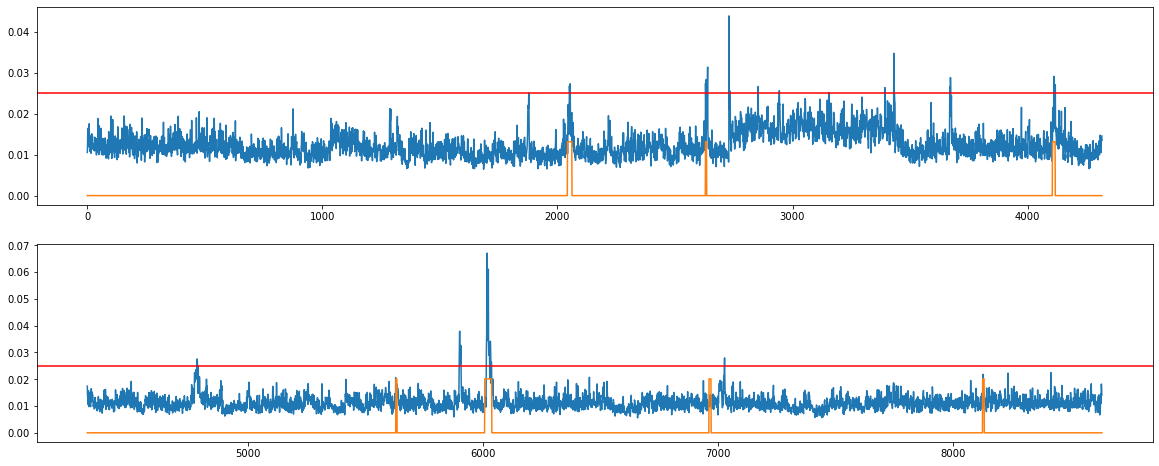

In [37]:
check_graph(anomaly_score, attack, piece=2, THRESHOLD=THRESHOLD)

In [38]:
# SIMPLE MOVING AVERAGE
sma = pd.DataFrame()
anomaly_score_series = pd.Series(anomaly_score)
sma[f'sma_{WINDOW_SIZE}_10'] = anomaly_score_series.rolling(window=20, min_periods=1).median()   # mean(average) 대신 median으로 이상치에 대한 영향을 줄임.
sma = np.ravel(sma.to_numpy())
sma.shape

(8635,)

In [39]:
THRESHOLD = 0.013

labels = put_labels(sma, THRESHOLD)
labels, labels.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (8635,))

In [40]:
%%time

final_labels = fill_blank(ts, labels, np.array(df_valid_raw['timestamp']))
final_labels.shape

Wall time: 5.22 s


(86400,)

In [41]:
attack_labels.shape[0] == final_labels.shape[0]

True

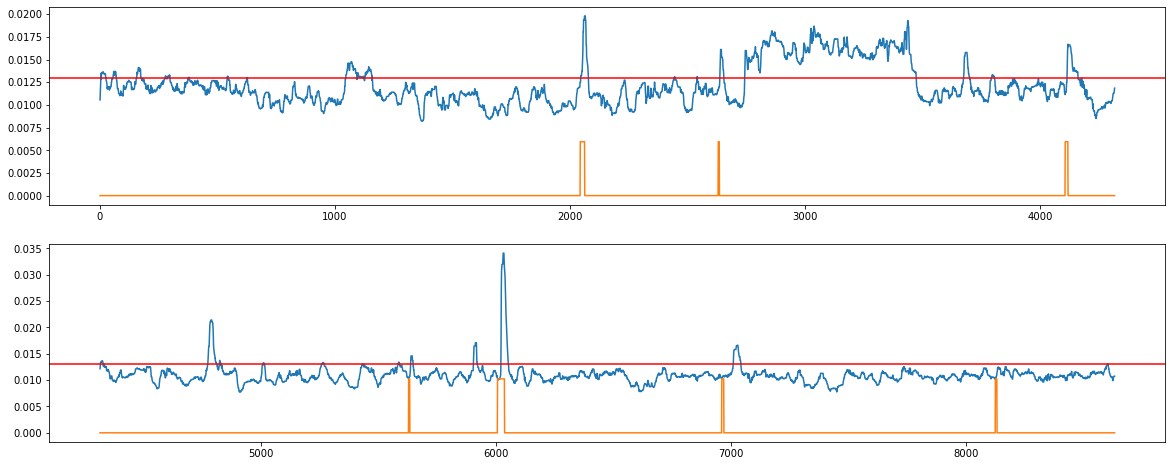

In [42]:
check_graph(sma, attack, piece=2, THRESHOLD=THRESHOLD)

In [43]:
TaPR = etapr.evaluate_haicon(anomalies=attack_labels, predictions=final_labels)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []


In [44]:
for i in range(0, 5):
    THRESHOLD = 0.0125 - i * 0.0001
    labels = put_labels(sma, THRESHOLD)
    final_labels = fill_blank(ts, labels, np.array(df_valid_raw['timestamp']))
    TaPR = etapr.evaluate_haicon(anomalies = attack_labels, predictions = final_labels)

    print(f"Threshold : {THRESHOLD}")
    print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
    print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
    print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")
    print('')

Threshold : 0.0125
F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []

Threshold : 0.012400000000000001
F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []

Threshold : 0.0123
F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []

Threshold : 0.0122
F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []

Threshold : 0.012100000000000001
F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []



In [45]:
df_test_raw = csvs2df(test_list)
df_test = normalize(df_test_raw[valid_col_in_train]).ewm(alpha=0.9).mean()
df_test

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.455432,0.0,0.079812,0.479046,0.077046,0.434169,0.711769,0.0,0.0,0.0,...,0.378726,0.095024,0.285153,0.068104,0.381526,0.0,0.393961,0.0,0.0,0.168791
1,0.471678,0.0,0.079812,0.499628,0.077046,0.429998,0.711769,0.0,0.0,0.0,...,0.377826,0.099579,0.285153,0.069240,0.404094,0.0,0.393961,0.0,0.0,0.173300
2,0.459304,0.0,0.079812,0.482713,0.077046,0.410346,0.711769,0.0,0.0,0.0,...,0.378191,0.103601,0.285153,0.068779,0.429462,0.0,0.393961,0.0,0.0,0.176731
3,0.458079,0.0,0.079812,0.478654,0.077046,0.408400,0.711769,0.0,0.0,0.0,...,0.379124,0.109204,0.285153,0.068734,0.461282,0.0,0.393961,0.0,0.0,0.178719
4,0.380719,0.0,0.079812,0.515098,0.077046,0.367874,0.711769,0.0,0.0,0.0,...,0.379218,0.109763,0.285153,0.066761,0.472272,0.0,0.393961,0.0,0.0,0.182832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.511523,0.0,0.017216,0.516825,0.147339,0.557125,0.711717,0.0,0.0,0.0,...,0.245764,0.130889,0.240398,0.327644,0.529605,0.0,0.539339,0.0,0.0,0.010225
129596,0.512114,0.0,0.017216,0.461690,0.135262,0.557380,0.711717,0.0,0.0,0.0,...,0.241081,0.131212,0.240398,0.320111,0.540804,0.0,0.539339,0.0,0.0,0.010225
129597,0.553332,0.0,0.017216,0.493026,0.133167,0.590276,0.711717,0.0,0.0,0.0,...,0.240613,0.130586,0.240398,0.306708,0.545617,0.0,0.539339,0.0,0.0,0.010225
129598,0.587329,0.0,0.017216,0.519678,0.132821,0.603950,0.711717,0.0,0.0,0.0,...,0.240566,0.128753,0.240398,0.287885,0.550216,0.0,0.539339,0.0,0.0,0.010225


In [46]:
check_ts, X_test, y_test = HaiDataset(df_test_raw['timestamp'], df_test, attacks = None)

  0%|          | 0/274741 [00:00<?, ?it/s]

# of valid windows: 27463


In [47]:
aux_test = []

for i in range(len(X_test)):
    aux_test.append(X_test[i][0])

aux_test = np.array(aux_test)

In [48]:
## MODEL PREDICTION

y_pred = model.predict([X_test, aux_test])

In [49]:
tmp = []

for i in range(len(y_test)):
    tmp.append(abs(y_test[i] - y_pred[i]))

anomaly_score = np.mean(tmp, axis=1)

In [50]:
# SIMPLE MOVING AVERAGE
sma = pd.DataFrame()
anomaly_score_series = pd.Series(anomaly_score)
sma[f'sma_{WINDOW_SIZE}_10'] = anomaly_score_series.rolling(window=10, min_periods=1).mean()
sma = np.ravel(sma.to_numpy())
sma.shape

(27463,)

In [51]:
anomaly_score

array([0.01053536, 0.01037232, 0.00916027, ..., 0.01255781, 0.00999899,
       0.01241675], dtype=float32)

In [52]:
import tensorflow as tf
tf.version

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)